# CS-E4895: Gaussian Processes (2023)

# Lab exercise #5

## Task 1: Gaussian process latent variable model (3 points)

The GPLVM is a non-linear, kernelized, probabilistic variant of PCA. We start from input datapoints $\mathbf{x} \in \mathbb{R}^D$ in a real-valued space $\mathbb{R}^D$. Our goal is to find the embedding $\mathbf{z} \in \mathbb{R}^Q$ for each datapoint $\mathbf{x}$, where $Q < D$. The GPLVM was described in lecture 7. 

The key idea of GPLVM is to model the mapping from latent space to data space as a GP,
\begin{align}
\mathbf{x}(\mathbf{z}) \sim \mathcal{GP}(m(\mathbf{z}), k( \mathbf{z}, \mathbf{z}')),
\end{align}
where each dimension $d = 1,\ldots,D$ has its own univariate-output GP.

The GPLVM has two main learning targets. In conventional GPLVM we optimize point estimates for $\mathbf{Z},\theta$ by maximum likelihood
\begin{align}
\mathrm{maximize} \quad \log p(\mathbf{X} | \mathbf{Z}, \theta) \propto -D/2 \log | \mathbf{K}_{ZZ}| - 1/2 tr( \mathbf{K}_{ZZ}^{-1} \mathbf{X} \mathbf{X}^T),
\end{align}
or by MAP
\begin{align}
\mathrm{maximize} \quad \log p(\mathbf{X} | \mathbf{Z}, \theta) + \log p(\mathbf{Z}). 
\end{align}

Finally, the Bayesian GPLVM is a model where we also aim to marginalize the distribution of latent variables and infer the variational posterior $q(\mathbf{Z})$ of the latent variables. This is useful since it gives an uncertainty (eg. $\mathrm{var}[q(\mathbf{Z})]$) for the embeddings.

In this task you compare PCA, GPLVM and Bayesian GPLVM on "oilflow" dataset https://inverseprobability.com/3PhaseData. The dataset contains 1000 datapoints with 12 covariates, and are labelled into three categories. If you run into computational problems, you can use a subset of the data.

You can use any GPLVM implementation available online. For this task, we recommend gpflow (tensorflow-based) because that's what we have tested on, but GPyTorch (torch-based) would likely be good as well. Both frameworks have helpful documentation and examples: See:
- https://gpflow.readthedocs.io/en/v1.5.1-docs/intro.html 
- https://nbviewer.org/github/GPflow/GPflow/blob/develop-1.0/doc/source/notebooks/intro.ipynb?flush_cache=true. 

Tasks:
- **Task1a**: Perform PCA and visualise the data using two principal components
- **Task1b**: Perform GPLVM and visualise the latent embedding. Can you see any differences to PCA. Can you explain why?
- **Task1c**: Perform Bayesian GPLVM and try to visualise the embeddings as Gaussians (eg. by 95% contours). Does the uncertainty look reasonable? Does the result differ from regular GPLVM?


In [2]:
#!pip install gpflux==0.4.1
#!pip install gpflow==2.7.1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import gpflow
import gpflux
import tensorflow as tf
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt

In [4]:
data = pd.read_csv("DataTrn.txt", header=None, sep='\s+')[:1000]
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.3315,0.2156,0.6802,0.1434,0.6825,0.2720,0.6223,0.2092,0.7961,0.1530,0.5856,0.2573
1,0.0939,1.0089,0.0365,0.6944,0.0908,0.4961,0.0722,0.6521,-0.0130,0.6085,0.0631,0.6597
2,0.5184,0.2283,0.5300,0.6884,0.7456,0.6171,0.6136,0.5928,0.7678,0.6130,0.6705,0.5202
3,0.4208,0.6740,0.1651,0.7592,0.1810,0.5448,0.1707,0.7554,0.1635,0.5492,0.2598,0.6455
4,0.3130,0.6465,0.5908,0.6924,0.7664,0.6262,1.7177,0.0150,0.0851,1.9046,-0.0165,0.0221


<AxesSubplot:xlabel='0', ylabel='2'>

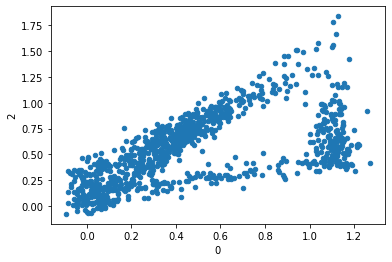

In [5]:
# visualizing
data.plot(0,2,"scatter")

In [6]:
data = data.to_numpy()
n_samples, n_features = data.shape
print("Number of samples:", n_samples)
print("Number of features:", n_features)

Number of samples: 1000
Number of features: 12


In [7]:
# Complete the above task here (unsupervised)
# There is no labels => this is generative model, which explains the distribution over the data p(x) (unknown)
# Task 1a no need to consult lecture slides (PCA - linear)
# Task 1b GPLVM (non linear, alternative to PCA, which has fixed W and z)
# GPLVM can use either MAP or Maximum Likelihood
# Task 1c Bayesian GPLVM (alternative to PCA), having distributions over W and z using VI q(Z)

# Task 1a

Perform PCA and visualise the data using two principal components

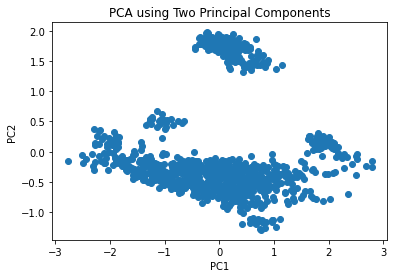

In [8]:
pca = PCA(n_components=2).fit(data)
data_transformed = pca.transform(data)
#pca.components_

#print(data_transformed)
# Visualize data using two principal components
plt.scatter(data_transformed[:, 0], data_transformed[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA using Two Principal Components')
plt.show()

# Task 1b

Perform GPLVM and visualise the latent embedding. Can you see any differences to PCA. Can you explain why?

In [9]:
# https://gpflow.github.io/GPflow/2.7.1/api/gpflow/models/index.html#gpflow.models.GPLVM
# class gpflow.models.GPLVM(data, latent_dim, X_data_mean=None, kernel=None, mean_function=None)
# Bases: GPR
# Standard GPLVM where the likelihood can be optimised with respect to the latent X.
# Parameters:
# data (Union[ndarray[Any, Any], Tensor, Variable, Parameter]) –
# latent_dim (int) –
# X_data_mean (Optional[Tensor]) –
# kernel (Optional[Kernel]) –
# mean_function (Optional[MeanFunction]) –

latent_dim = 2  # number of latent dimensions

lengthscales = tf.convert_to_tensor([1.0] * latent_dim)
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

GPLVM = gpflow.models.GPLVM(
    data=tf.convert_to_tensor(data),
    latent_dim=latent_dim,
    kernel=kernel,
)

GPLVM.likelihood.variance.assign(0.01)

# https://gpflow.github.io/GPflow/2.7.1/api/gpflow/optimizers/index.html
opt = gpflow.optimizers.Scipy()
maxiter = 30
# minimize(closure, variables, method='L-BFGS-B', step_callback=None, compile=True, allow_unused_variables=False, **scipy_kwargs)
opt.minimize(
    closure=GPLVM.training_loss,
    variables=GPLVM.trainable_variables,
    method="BFGS",
    options=dict(maxiter=maxiter),
)

print("Finished training GPLVM")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Finished training GPLVM


In [10]:
print_summary(GPLVM, fmt='fancy_table')

name                       class      transform         prior    trainable    shape      dtype    value
-------------------------  ---------  ----------------  -------  -----------  ---------  -------  ----------------------
GPLVM.kernel.variance      Parameter  Softplus                   True         ()         float64  1.09924
GPLVM.kernel.lengthscales  Parameter  Softplus                   True         (2,)       float64  [0.0387  1.16872]
GPLVM.likelihood.variance  Parameter  Softplus + Shift           True         ()         float64  0.00585
GPLVM.data[0]              Parameter  Identity                   True         (1000, 2)  float64  [[-0.41947, 0.82572...


In [11]:
X_reduced = GPLVM.data[0].numpy()
print(X_reduced.shape)

(1000, 2)


Text(0, 0.5, 'Latent Dimension 2')

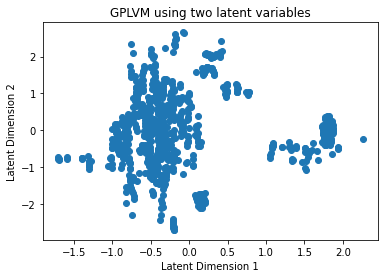

In [12]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.title("GPLVM using two latent variables")
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

Can you see any differences to PCA? Can you explain why?

https://www.researchgate.net/figure/Comparison-of-latent-spaces-learned-by-LVMs-a-PCA-b-GPLVM-and-c-BGPLVM-The-axes-are_fig2_332685681

Features of PC:
- PCA is a linear technique that identifies the directions of maximal variance in the data 
- PCA projects the data onto these directions. The principal components are orthogonal and capture the variance in the data in decreasing order. 
- PCA assumes that the data follows Gaussian distribution and that the high-dimensional data can be approximated by a lower-dimensional linear subspace.

Features of GPLVM: 
- GPLVM is a non-linear technique that uses GP to model the mapping between the high-dimensional data and the low-dimensional latent space. 
-  GPLVM aims to find the low-dimensional latent representation that preserves the pairwise distances between the data points as closely as possible.

The differences:
- The clusters in the PCA scatter plot are spread out along the two principal components
- the clusters in GPLVM are packed in an ellipse shape across both latent dimensions

Reasons:

Interpretation: 
- the axes in latent dimensions for PCA correspond to some linear combinations of the original features
- the axes in latent dimensions for GPLVM correspond to some nonlinear functions of the original features.

Dimensionality reduction
- PCA seeks to find a low-dimensional subspace that captures the maximum variance in the data => the clusters in the PCA scatter plot may be more spread out along the principal components
- GPLVM tries to map the data to a low-dimensional latent space to reflect their similarity in the original feature space => the clusters in GPLVM are tightly packed and have a complex shape due to the non-linear mapping

Reconstruction:  
- PCA can reconstruct the original data points using the first few principal components
- GPLVM cannot reconstruct the original data points.

# Task 1c

Perform Bayesian GPLVM and try to visualise the embeddings as Gaussians (eg. by 95% contours). Does the uncertainty look reasonable? Does the result differ from regular GPLVM?

In [16]:
# Tutorial: https://gpflow.github.io/GPflow/develop/notebooks/advanced/GPLVM.html

# https://gpflow.github.io/GPflow/2.7.1/api/gpflow/models/index.html#gpflow.models.BayesianGPLVM
# gpflow.models.BayesianGPLVM
# class gpflow.models.BayesianGPLVM(data, X_data_mean, X_data_var, kernel, num_inducing_variables=None, inducing_variable=None, X_prior_mean=None, X_prior_var=None)[source]
# Bases: GPModel, InternalDataTrainingLossMixin
# Parameters:
# data (Union[ndarray[Any, Any], Tensor, Variable, Parameter]) –
# X_data_mean (Tensor) –
# X_data_var (Tensor) –
# kernel (Kernel) –
# num_inducing_variables (Optional[int]) –
# inducing_variable (Union[InducingVariables, Tensor, ndarray[Any, Any], None]) –
# X_prior_mean (Union[ndarray[Any, Any], Tensor, Variable, Parameter, None]) –
# X_prior_var (Union[ndarray[Any, Any], Tensor, Variable, Parameter, None]) –latent_dim = 2  # number of latent dimensions

latent_dim = 2  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = data.shape[0]  # number of data points

X_mean_init = ops.pca_reduce(data, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

np.random.seed(1)  # for reproducibility
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing],
    dtype=default_float(),
)

lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

BayesGPLVM = gpflow.models.BayesianGPLVM(
    data=tf.convert_to_tensor(data),
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
)

BayesGPLVM.likelihood.variance.assign(0.01)

opt = gpflow.optimizers.Scipy()
maxiter = 50
opt.minimize(
    closure=BayesGPLVM.training_loss,
    method="BFGS",
    variables=BayesGPLVM.trainable_variables,
    options=dict(maxiter=maxiter),
)

print("Finished training Bayesian GPLVM")

Finished training Bayesian GPLVM


In [17]:
print_summary(GPLVM, fmt='fancy_table')

name                       class      transform         prior    trainable    shape      dtype    value
-------------------------  ---------  ----------------  -------  -----------  ---------  -------  ----------------------
GPLVM.kernel.variance      Parameter  Softplus                   True         ()         float64  1.09924
GPLVM.kernel.lengthscales  Parameter  Softplus                   True         (2,)       float64  [0.0387  1.16872]
GPLVM.likelihood.variance  Parameter  Softplus + Shift           True         ()         float64  0.00585
GPLVM.data[0]              Parameter  Identity                   True         (1000, 2)  float64  [[-0.41947, 0.82572...


In [18]:
X_mean = BayesGPLVM.X_data_mean.numpy()
X_var = BayesGPLVM.X_data_var.numpy()
print(X_mean.shape)
print(X_var.shape)

(1000, 2)
(1000, 2)


We can visualize the individual Gaussians as ellipses that contain 95% of the probability mass of the distributions (so 2 standard deviations away from the means). We used matplotlib.patches.Ellipse for this, and the Bayesian GPLVM object should have the attributes X_data_mean and X_data_var for each data point.

Text(0, 0.5, 'Latent Dimension 2')

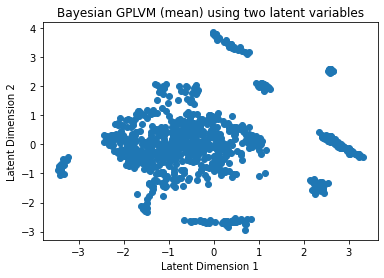

In [19]:
gplvm_X_mean = BayesGPLVM.X_data_mean.numpy()
plt.scatter(gplvm_X_mean[:, 0], gplvm_X_mean[:, 1])
plt.title("Bayesian GPLVM (mean) using two latent variables")
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

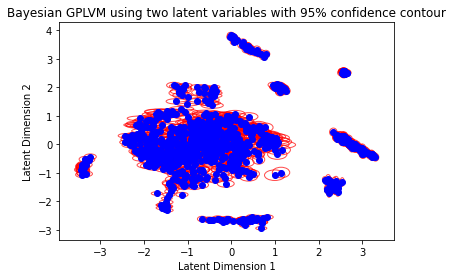

In [20]:
from matplotlib.patches import Ellipse

# define the number of standard deviations to contain 95% of the probability mass
num_stddev = 2

# compute the standard deviation
X_stddev = tf.sqrt(X_var)

# create a new figure
plt.figure()
ax = plt.gca()

# plot the ellipses
for i in range(X_mean.shape[0]):
    ellipse = Ellipse(xy = (X_mean[i, 0], X_mean[i, 1]), 
                      width = num_stddev * X_stddev[i, 0], 
                      height = num_stddev * X_stddev[i, 1],
                      facecolor='None',
                      edgecolor='r',
                      alpha = 0.7)
    ax.add_patch(ellipse)

# plot the mean points
ax.scatter(X_mean[:, 0], X_mean[:, 1], color='blue')

plt.title("Bayesian GPLVM using two latent variables with 95% confidence contour")
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')

# show the plot
plt.show()



Does the uncertainty look reasonable? Does the result differ from regular GPLVM?

Yes, the uncertainty look reasonable to me.

In regular GPLVM, each embedding is a point estimate, so there is no notion of uncertainty.

In the Bayesian GPLVM, the embeddings are not point estimates, but instead each is an individual Gaussian distribution with a mean and variances along the two dimensions, and these distributions can be visualised.

The result of Bayesian GPLVM differs from regular GPLVM in that the former can capture the uncertainty of the embedding. For example, if the ellipses of two data points overlap, it indicates that there is less certainty in the true difference between these two data points, which is relevant to the decision-making process.

## Task 2: Sampling from a Deep GP (1 point)

In this task we will explore sampling from deep Gaussian processes. DGPs were covered in lecture 9. You are provided the code below to assist you.


In [21]:
# we only need numpy for this one
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(111)
N = 500
x = np.linspace(-20, 20, num=N)

gp_var = 1.0  # GP variance
gp_len = 1.0  # GP lengthscale

def rbf_kernel(x1, x2):
    x1 = x1.reshape(-1, 1, 1)
    x2 = x2.reshape(1, -1, 1)
    r = np.sum(x1 - x2, axis=-1)
    return gp_var * np.exp(-0.5 * np.square(r) / np.square(gp_len))

def zero_mean(X):
    return np.zeros_like(X.reshape(-1, ))

def identity_mean(X):
    return X.reshape(-1, )

# Task 2a

Generate a sample from a 3-layer deep GP with **zero mean** and an **RBF kernel**. Use the inputs, x, and parameters given above. Plot the sample path and the covariance matrix in each layer.

**Do you notice any strange behaviour in the sample path and/or covariance matrix? Write a short explanation of the behaviour and why you think it may be occuring.**

hint 1: you can use np.random.multivariate_normal() to sample from a Gaussian distribution. ***Note: you may need to add a small value to the diagonal of the covariance matrix to prevent numerical issues during sampling, e.g. + 1e-10 * np.eye(N)***

hint 2: use plt.imshow() to plot a covariance matrix

hint 3: always plot the initial inputs, x, on the x-axis of the sample plots.

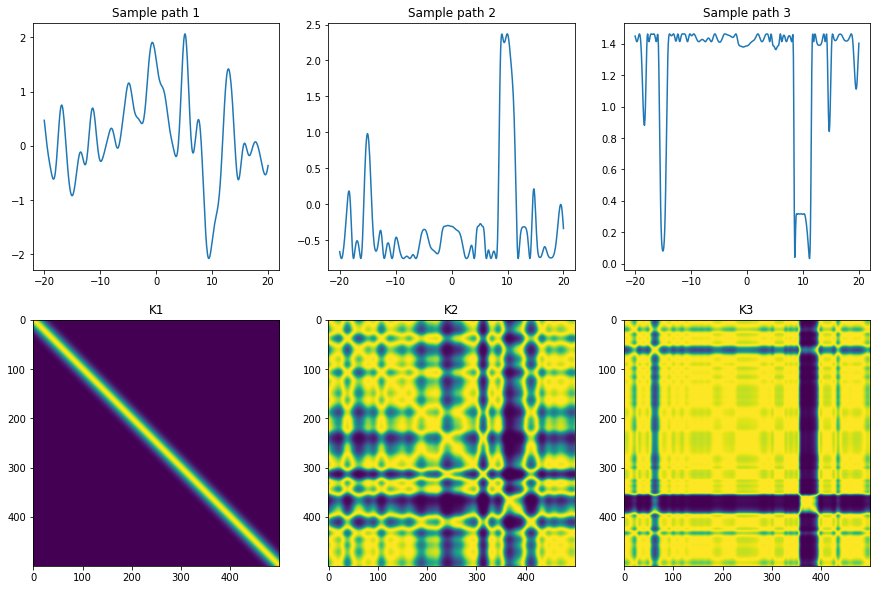

In [22]:
## TODO complete the above task here

# sample1, sample2 have the same shape in lecture slide 7 

# takes the f, push through the GP layers

## TODO complete the above task here

jitter = 1e-10 * np.eye(N)
K1 = rbf_kernel(x, x) 
f1 = np.random.multivariate_normal(mean=zero_mean(x), cov=K1)
K2 = rbf_kernel(f1, f1) 
f2 = np.random.multivariate_normal(mean=zero_mean(x), cov=K2 + jitter)
K3 = rbf_kernel(f2, f2) 
f3 = np.random.multivariate_normal(mean=zero_mean(x), cov=K3 + jitter)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axs[0][0].plot(x, f1)
axs[0][0].set_title('Sample path 1')

axs[1][0].imshow(K1)
axs[1][0].set_title('K1')

axs[0][1].plot(x, f2)
axs[0][1].set_title('Sample path 2')

axs[1][1].imshow(K2)
axs[1][1].set_title('K2')

axs[0][2].plot(x, f3)
axs[0][2].set_title('Sample path 3')

axs[1][2].imshow(K3)
axs[1][2].set_title('K3')

plt.show()

Do you notice any strange behaviour in the sample path and/or covariance matrix? Write a short explanation of the behaviour and why you think it may be occuring.

I found no anomaly in the first layer, which is the normal RBF kernel.

However, the second and third GP layer demonstrates some notable anomalies.

First are the sharp jumps and discontinuities. We can see the sample path in 2nd and 3rd layers mostly oscillate around a small range, but have some occasion sharp jumps that have great magnitude, which causes discontinuities.  

Second is the highly nonstationary smoothness. From the kernel heatmap, we can see that the continuity of smoothness (color transition) is sporadic along the second layer kernel, while it is abrupt in the third layer. 

As a result, samples from the second and third layers follow a rich space of functions

# Task 2b

Now generate a sample from a 3-layer deep GP, now with the **identity mean function for the first two layers**, and a **zero mean function for the final layer**. Plot the samples from each layer and the covariance matrices.

Do you notice any differences in the behaviour between this sample and the previous one? Write a short explanation.

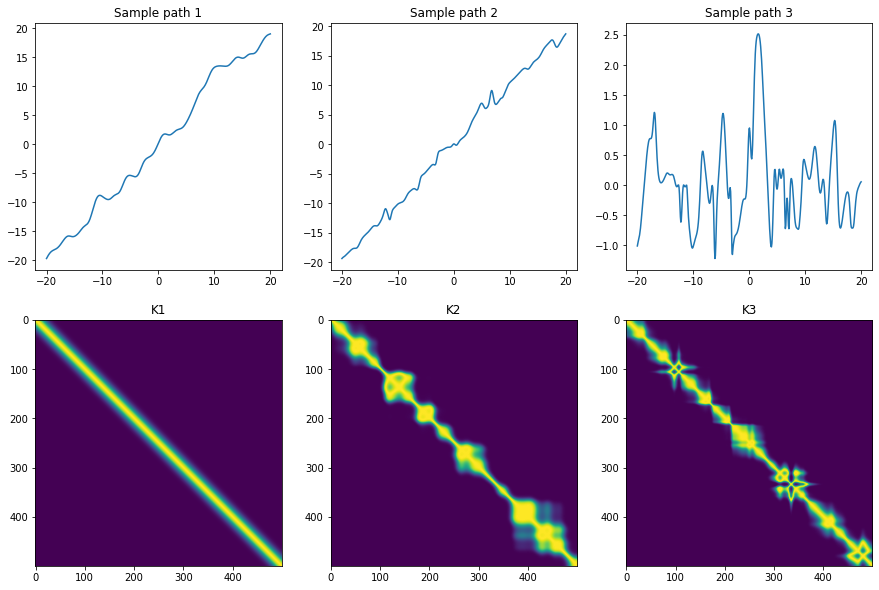

In [23]:
jitter = 1e-10 * np.eye(N)
K1 = rbf_kernel(x, x) 
f1 = np.random.multivariate_normal(mean=identity_mean(x), cov=K1)
K2 = rbf_kernel(f1, f1) 
f2 = np.random.multivariate_normal(mean=identity_mean(x), cov=K2 + jitter)
K3 = rbf_kernel(f2, f2) 
f3 = np.random.multivariate_normal(mean=zero_mean(x), cov=K3 + jitter)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

axs[0][0].plot(x, f1)
axs[0][0].set_title('Sample path 1')

axs[1][0].imshow(K1)
axs[1][0].set_title('K1')

axs[0][1].plot(x, f2)
axs[0][1].set_title('Sample path 2')

axs[1][1].imshow(K2)
axs[1][1].set_title('K2')

axs[0][2].plot(x, f3)
axs[0][2].set_title('Sample path 3')

axs[1][2].imshow(K3)
axs[1][2].set_title('K3')

plt.show()

Do you notice any differences in the behaviour between this sample and the previous one? Write a short explanation.

Yes, the difference is now clear in that in 2b, the high values in the heatmap still concentrate on the main diagonal instead of spreading out over the kernel like in 2a. Initially we have a uniform input, but later on, the diagonal accumulates more clumping. The reason is that the input to the second layer is a mean of a sample from the first kernel, so it at least retains the information from the first kernel. As a result, the small fluctuations in the first sample causes the main diagonal in the second kernel to gathers some clumps. This effect is magnified in the third layer, where the kernel is calculated by a sample from the second layer. 

## Task 3: Deep Gaussian processes in practise (2 points)

In this task we will use DGPs to learn the "jump" dataset shown below. In this task you will use the GPflux https://secondmind-labs.github.io/GPflux, which is based on Keras, Tensorflow and gpflow packages. You are free to use their tutorials and documentation to help you. Start from https://secondmind-labs.github.io/GPflux/notebooks/intro.html.

- **task3a**: Fit the data with a single GP, two-layer GP and three-layer GP. Visualise the resulting fits as best as you can, try to also visualise the uncertainty of the predictive distribution. What differences do you see between the models, and why? Discuss.
- **task3b**: Did you encounter any issues with the deep GPs? 


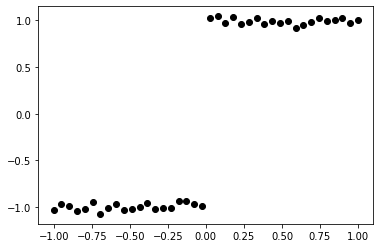

In [24]:
np.random.seed(123)
N = 40
X_train = np.linspace(-1, 1, N)[:, None]
f_step = lambda x: -1 if x < 0 else 1.
Y_train = np.reshape([f_step(x) for x in X_train], X_train.shape) + np.random.randn(*X_train.shape) * 0.03
Xs = np.linspace(-2., 2, 300)[:, None]  # test inputs
plt.scatter(X_train, Y_train, color='k');

# Task 3a

In [25]:
N = 40
output_dim = 1
num_inducing = 10

def GPLayers(X, numLayers):
    kernel = gpflow.kernels.SquaredExponential()
    inducing_variable = gpflow.inducing_variables.InducingPoints(
        np.linspace(X.min(), X.max(), num_inducing).reshape(-1,1)
    )
    mean_funcs = [gpflow.mean_functions.Identity()] * (numLayers - 1) + [gpflow.mean_functions.Zero()]

    GP_layers = [
        gpflux.layers.GPLayer(
          kernel,
          inducing_variable,
          num_data=N,
          num_latent_gps=output_dim,
          mean_function=mean_funcs[i])
        for i in range(numLayers)]
    
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    layers_dgp = gpflux.models.DeepGP(GP_layers, likelihood_layer)
    return layers_dgp

In [30]:
def plot(model, X_test, X_train, Y_train, title):

    fig, ax = plt.subplots(figsize = (7,5))

    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 2 * np.sqrt(var)
    upper = mu + 2 * np.sqrt(var)

    ax.set_ylim(Y_train.min() - 1, Y_train.max() + 1)
    ax.plot(X_train, Y_train, "kx", alpha=0.5, label="Training data")
    ax.plot(X_test, mu, "r", label="Mean prediction", linewidth=0.5)
    ax.plot(X_test, mu-2*np.sqrt(var), '--', c='k', linewidth=0.7)
    ax.plot(X_test, mu+2*np.sqrt(var), '--', c='k', label='upper and lower bound', linewidth=0.7)
    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3, label = "95% confidence")
    ax.set_title(title)
    ax.legend(framealpha=0, loc=4)

# One layer GP

In [27]:
model1 = GPLayers(X_train, 1)
model_as_train1 = model1.as_training_model()
model_as_train1.compile(tf.optimizers.Adam(0.01))
history1 = model_as_train1.fit({"inputs": X_train, "targets": Y_train}, epochs=1000,verbose=0)

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
C:\Users\nguye\AppData\Local\Temp\ipykernel_3168\2382217012.py:21: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


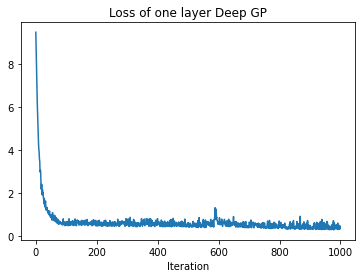

In [28]:
plt.title("Loss of one layer Deep GP")
plt.xlabel("Iteration")
plt.plot(history1.history["loss"])

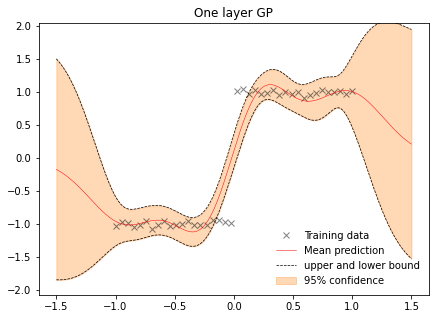

In [31]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
plot(model1.as_prediction_model(), X_test, X_train, Y_train, "One layer GP")

# Two layers GP

In [32]:
model2 = GPLayers(X_train, 2)
model_as_train2 = model2.as_training_model()
model_as_train2.compile(tf.optimizers.Adam(0.01))
history2 = model_as_train2.fit({"inputs": X_train, "targets": Y_train}, epochs=1000,verbose=0)

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
C:\Users\nguye\AppData\Local\Temp\ipykernel_3168\2382217012.py:21: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


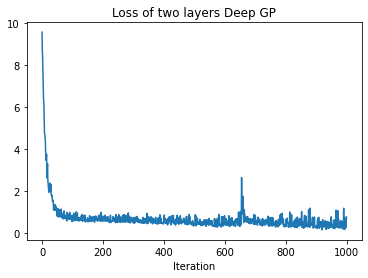

In [33]:
plt.title("Loss of two layers Deep GP")
plt.xlabel("Iteration")
plt.plot(history2.history["loss"])

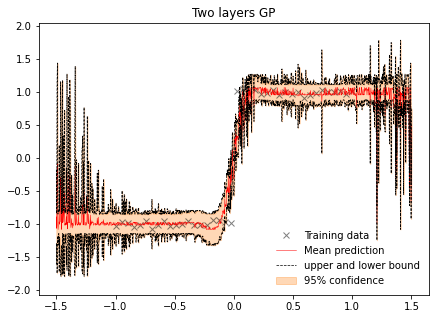

In [34]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
plot(model2.as_prediction_model(), X_test, X_train, Y_train, "Two layers GP")

# Three layers GP

In [35]:
model3 = GPLayers(X_train, 3)
model_as_train3 = model3.as_training_model()
model_as_train3.compile(tf.optimizers.Adam(0.01))
history3 = model_as_train3.fit({"inputs": X_train, "targets": Y_train}, epochs=1000,verbose=0)

c:\Users\nguye\AppData\Local\Programs\Python\Python310\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
C:\Users\nguye\AppData\Local\Temp\ipykernel_3168\2382217012.py:21: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


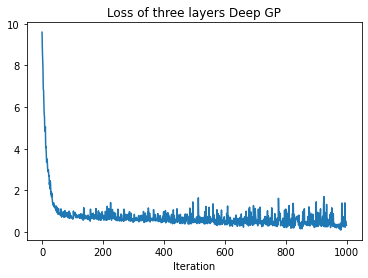

In [36]:
plt.title("Loss of three layers Deep GP")
plt.xlabel("Iteration")
plt.plot(history3.history["loss"])

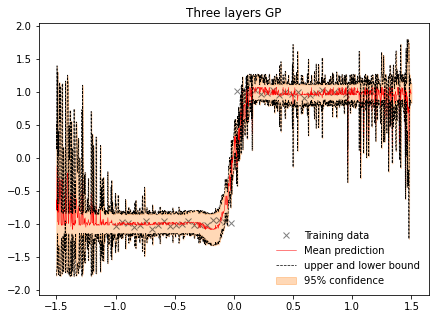

In [37]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
plot(model2.as_prediction_model(), X_test, X_train, Y_train, "Three layers GP")

What differences do you see between the models, and why? Discuss.

One layer version: The confidence interval is smooth and has a sigmoid-like transition between the gap in the jump dataset. Outside the dataset, the confidence interval expands rapidly to account for the uncertainties. Additionally, the error history fluctuates in a tiny range. The smoothness suggest that the deep GP does not overfit the data and can generalize well to unknown jumping data.

Two layers version: the confidence interval becomes sharper and sporadic. The connection between the gap has a sharper corner than the one layer version. We can also observe that the regions far from the dataset have abnormal spikes, which hints that the GP believes this dataset is repeated in a cycle if given more datapoints. The error history also observe larger fluctuations than the one GP layer version.

Three layers version: the confidence interval is highly turbulent and have very small width, suggest that the deep GP overfits the data. The connection between the gaps is a straight line without any smoothness at the bending corners. The repeating cycle is also present like the two-layers version and the error history observe larger fluctuations than the one and two GP layers version.

# Task 3b

Did you encounter any issues with the deep GPs?

Yes, I encountered so many incompatibility issues, the error about tensorflow not being able to convert numpy float64 and much more, as you can observe from the logged warnings above

However, it is safe to assume that the one layer version underfits the data, the two layers is adequate and the three layers overfit the data, in my opinion. Regarding this finding, I don't believe I have any issues with the correctness of the models.  